# Graph autoencoder

The graph autoencoder is our first GNN for link prediction. As opposed to the heuristics and latent-feature methods which serve as our baselines, it is capable of taking into account both the graph structure and the node features to predict links correctly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import LinkPredictionDataset

import json
import os
import os.path as osp
import time

from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GAE, GCNConv 
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import RandomLinkSplit 

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [3]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [4]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [5]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation average precision is:', df_best[variable].unique()[0])

In [6]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("---------------------------------------------------------------------")
    line_new = "{:>25}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("---------------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>25}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("---------------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [7]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")  
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch Geometric implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.GAE) of a graph autoencoder `GAE`. 

With GAEs, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `out_channels`: size of each output sample. It gives us the dimension of the embeddings in the output layer.
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the GNN used as encoder. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting. We now perform the hyperparameter tuning using loops.

In [7]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [9]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout_prob):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=dropout_prob, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()
    z_train = model.encode(train_data.x, train_data.edge_index)
    loss_train = model.recon_loss(z_train, train_data.pos_edge_label_index, train_data.neg_edge_label_index) # set negative edges!
    loss_train.backward()
    optimizer.step()
    model.eval()
    z_val = model.encode(val_data.x, val_data.edge_index)
    loss_val = model.recon_loss(z_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    z_test = model.encode(test_data.x, test_data.edge_index)
    loss_test = model.recon_loss(z_test, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return loss_train, loss_val, loss_test, z_train, z_val, z_test

@torch.no_grad()
def test():
    model.eval()
    z_train = model.encode(train_data.x, train_data.edge_index)
    z_val = model.encode(val_data.x, val_data.edge_index)
    z_test = model.encode(test_data.x, test_data.edge_index)
    train_auc, train_ap = model.test(z_train, train_data.pos_edge_label_index, train_data.neg_edge_label_index)
    val_auc, val_ap = model.test(z_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    test_auc, test_ap = model.test(z_test, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return train_auc, val_auc, test_auc, train_ap, val_ap, test_ap

In [ ]:
start_time = time.time()
torch_geometric.seed_everything(0)

gae_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_aucs', 'val_aucs', 
                                      'test_aucs', 'train_aps', 'val_aps', 'test_aps', 'best_train_losses', 'best_val_losses', 
                                      'best_test_losses', 'best_train_aucs', 'best_val_aucs', 'best_test_aucs', 
                                      'best_train_aps', 'best_val_aps', 'best_test_aps', 'mean_best_train_loss', 
                                      'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_auc', 'mean_best_val_auc', 
                                      'mean_best_test_auc', 'mean_best_train_ap', 'mean_best_val_ap', 'mean_best_test_ap', 
                                      'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 'std_best_train_auc', 
                                      'std_best_val_auc', 'std_best_test_auc', 'std_best_train_ap', 'std_best_val_ap', 
                                      'std_best_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [16, 32]: 
    for out_channels in [8, 16]: 
        for dropout_prob in [0.1, 0.3, 0.5]:
            for learning_rate in [0.001, 0.01, 0.1]: 
                for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4]: 
                    for patience in [3, 5, 10]: 
                
                        # Hyperparamter tuning

                        print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, out_channels: {out_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                        parameter_dict = dict({'hidden_channels': hidden_channels, 'out_channels': out_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                        loss_dict = dict()
                        val_loss_dict = dict()
                        test_loss_dict = dict()
                        train_auc_dict = dict()                        
                        val_auc_dict = dict()
                        test_auc_dict = dict()
                        train_ap_dict = dict()
                        val_ap_dict = dict()
                        test_ap_dict = dict()

                        best_train_loss_dict = dict()
                        best_val_loss_dict = dict()
                        best_test_loss_dict = dict()
                        best_train_auc_dict = dict()
                        best_val_auc_dict = dict()
                        best_test_auc_dict = dict()
                        best_train_ap_dict = dict()
                        best_val_ap_dict = dict()
                        best_test_ap_dict = dict()

                        for i, seed in enumerate(seeds): 

                            torch_geometric.seed_everything(seed)
                            
                            dataset = LinkPredictionDataset(root='data/', transform=RandomLinkSplit(num_val=0.1, num_test=0.3, is_undirected=True, split_labels=True, add_negative_train_samples=True))
                            data = dataset[0]
                            train_data, val_data, test_data = data

                            model = GAE(GCNEncoder(hidden_channels = hidden_channels, dropout_prob = dropout_prob, out_channels = out_channels))

                            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

                            loss_list = []
                            val_loss_list = []
                            test_loss_list = []
                            train_auc_list = []
                            val_auc_list = []
                            test_auc_list = []
                            train_ap_list = []
                            val_ap_list = []
                            test_ap_list = []

                            last_loss = 100
                            patience = patience 
                            trigger_times = 0

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            for epoch in range(1, 101):
                                loss, val_loss, test_loss, z_train, z_val, z_test = train() 
                                train_auc, val_auc, test_auc, train_ap, val_ap, test_ap = test() 
                                loss_list += [loss.item()]
                                val_loss_list += [val_loss.item()]
                                test_loss_list += [test_loss.item()]
                                train_auc_list += [train_auc]
                                val_auc_list += [val_auc]
                                test_auc_list += [test_auc]
                                train_ap_list += [train_ap]                                
                                val_ap_list += [val_ap]
                                test_ap_list += [test_ap]

                                current_val_loss = val_loss

                                print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train auc: {train_auc:.4f}, val acc: {val_auc:.4f}, test acc: {test_auc:.4f}, train ap: {train_ap:.4f}, val ap: {val_ap:.4f}, test ap: {test_ap:.4f}')

                                if current_val_loss <= last_loss:
                                    current_best_train_loss = loss.item()
                                    current_best_val_loss = current_val_loss.item()
                                    current_best_test_loss = test_loss.item()
                                    current_best_train_auc = train_auc
                                    current_best_val_auc = val_auc
                                    current_best_test_auc = test_auc
                                    current_best_train_ap = train_ap
                                    current_best_val_ap = val_ap
                                    current_best_test_ap = test_ap

                                    trigger_times = 0
                                    print('Trigger times: 0')

                                    last_loss = current_val_loss

                                else: 
                                    trigger_times += 1
                                    print('Trigger times:', trigger_times)

                                    if trigger_times >= patience:
                                        print('Early stopping!')
                                        break

                            loss_dict.update({f"{i+1}": loss_list}) 
                            val_loss_dict.update({f"{i+1}": val_loss_list}) 
                            test_loss_dict.update({f"{i+1}": test_loss_list}) 
                            train_auc_dict.update({f"{i+1}": train_auc_list}) 
                            val_auc_dict.update({f"{i+1}": val_auc_list}) 
                            test_auc_dict.update({f"{i+1}": test_auc_list}) 
                            train_ap_dict.update({f"{i+1}": train_ap_list}) 
                            val_ap_dict.update({f"{i+1}": val_ap_list}) 
                            test_ap_dict.update({f"{i+1}": test_ap_list}) 

                            best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                            best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                            best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                            best_train_auc_dict.update({f"{i+1}": current_best_train_auc}) 
                            best_val_auc_dict.update({f"{i+1}": current_best_val_auc})
                            best_test_auc_dict.update({f"{i+1}": current_best_test_auc}) 
                            best_train_ap_dict.update({f"{i+1}": current_best_train_ap}) 
                            best_val_ap_dict.update({f"{i+1}": current_best_val_ap})
                            best_test_ap_dict.update({f"{i+1}": current_best_test_ap}) 

                            print(current_best_val_loss)

                        data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                        'test_losses': test_loss_dict, 'train_aucs': train_auc_dict, 'val_aucs': val_auc_dict, 
                                        'test_aucs': test_auc_dict, 'train_aps': train_ap_dict, 'val_aps': val_ap_dict, 
                                        'test_aps': test_ap_dict, 'best_train_losses': best_train_loss_dict, 
                                        'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                        'best_train_aucs': best_train_auc_dict, 'best_val_aucs': best_val_auc_dict, 
                                        'best_test_aucs': best_test_auc_dict, 'best_train_aps': best_train_ap_dict, 
                                        'best_val_aps': best_val_ap_dict, 'best_test_aps': best_test_ap_dict, 
                                        'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                        'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                        'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                        'mean_best_train_auc': mean(best_train_auc_dict.values()), 
                                        'mean_best_val_auc': mean(best_val_auc_dict.values()), 
                                        'mean_best_test_auc': mean(best_test_auc_dict.values()),
                                        'mean_best_train_ap': mean(best_train_ap_dict.values()), 
                                        'mean_best_val_ap': mean(best_val_ap_dict.values()), 
                                        'mean_best_test_ap': mean(best_test_ap_dict.values()),
                                        'std_best_train_loss': std(best_train_loss_dict.values()), 
                                        'std_best_val_loss': std(best_val_loss_dict.values()), 
                                        'std_best_test_loss': std(best_test_loss_dict.values()), 
                                        'std_best_train_auc': std(best_train_auc_dict.values()), 
                                        'std_best_val_auc': std(best_val_auc_dict.values()), 
                                        'std_best_test_auc': std(best_test_auc_dict.values()),
                                        'std_best_train_ap': std(best_train_ap_dict.values()), 
                                        'std_best_val_ap': std(best_val_ap_dict.values()), 
                                        'std_best_test_ap': std(best_test_ap_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        gae_results = pd.concat([gae_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gae_results.pkl")
gae_results.to_pickle(f"{route0}/gae_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [9]:
# Look at results
gae_results = pd.read_pickle(f"{route0}/gae_results.pkl") 
gae_results

## Best hyperparameter combination

In [10]:
filter_best_hyperparameters(gae_results, 'mean_best_val_ap')

,parameters,train_losses,val_losses,test_losses,train_aucs,val_aucs,test_aucs,train_aps,val_aps,test_aps,best_train_losses,best_val_losses,best_test_losses,best_train_aucs,best_val_aucs,best_test_aucs,best_train_aps,best_val_aps,best_test_aps,mean_best_train_loss,mean_best_val_loss,mean_best_test_loss,mean_best_train_auc,mean_best_val_auc,mean_best_test_auc,mean_best_train_ap,mean_best_val_ap,mean_best_test_ap,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_auc,std_best_val_auc,std_best_test_auc,std_best_train_ap,std_best_val_ap,std_best_test_ap
75,"{'hidden_channels': 16, 'out_channels': 8, 'dr...","{'1': [1.3470561504364014, 1.3351362943649292,...","{'1': [1.3471556901931763, 1.3426268100738525,...","{'1': [1.3464245796203613, 1.341780424118042, ...","{'1': [0.9035164927212407, 0.9087548947635569,...","{'1': [0.9017134894486367, 0.9063367225233524,...","{'1': [0.8985316134145268, 0.9039511355689128,...","{'1': [0.8994359079156486, 0.9109584026966888,...","{'1': [0.9081192909004847, 0.9162340981166203,...","{'1': [0.8997608512339328, 0.9101948533256868,...","{'1': 1.095542311668396, '2': 1.09642601013183...","{'1': 1.1117937564849854, '2': 1.1081905364990...","{'1': 1.1027748584747314, '2': 1.0943281650543...","{'1': 0.9238272053493105, '2': 0.9260280407037...","{'1': 0.9136081293324358, '2': 0.9109540510858...","{'1': 0.9223579603977806, '2': 0.9204478506919...","{'1': 0.9357114829263364, '2': 0.9372909098622...","{'1': 0.9275698623538393, '2': 0.9281960773998...","{'1': 0.9351196387871694, '2': 0.9340493284676...",1.097618,1.096361,1.094654,0.925108,0.916971,0.91928,0.936411,0.930326,0.932729,0.020353,0.028777,0.018222,0.0029,0.007824,0.005343,0.002008,0.006909,0.003492
76,"{'hidden_channels': 16, 'out_channels': 8, 'dr...","{'1': [1.3470561504364014, 1.3351362943649292,...","{'1': [1.3471556901931763, 1.3426268100738525,...","{'1': [1.3464245796203613, 1.341780424118042, ...","{'1': [0.9035164927212407, 0.9087548947635569,...","{'1': [0.9017134894486367, 0.9063367225233524,...","{'1': [0.8985316134145268, 0.9039511355689128,...","{'1': [0.8994359079156486, 0.9109584026966888,...","{'1': [0.9081192909004847, 0.9162340981166203,...","{'1': [0.8997608512339328, 0.9101948533256868,...","{'1': 1.095542311668396, '2': 1.09642601013183...","{'1': 1.1117937564849854, '2': 1.1081905364990...","{'1': 1.1027748584747314, '2': 1.0943281650543...","{'1': 0.9238272053493105, '2': 0.9260280407037...","{'1': 0.9136081293324358, '2': 0.9109540510858...","{'1': 0.9223579603977806, '2': 0.9204478506919...","{'1': 0.9357114829263364, '2': 0.9372909098622...","{'1': 0.9275698623538393, '2': 0.9281960773998...","{'1': 0.9351196387871694, '2': 0.9340493284676...",1.097618,1.096361,1.094654,0.925108,0.916971,0.91928,0.936411,0.930326,0.932729,0.020353,0.028777,0.018222,0.0029,0.007824,0.005343,0.002008,0.006909,0.003492
77,"{'hidden_channels': 16, 'out_channels': 8, 'dr...","{'1': [1.3470561504364014, 1.3351362943649292,...","{'1': [1.3471556901931763, 1.3426268100738525,...","{'1': [1.3464245796203613, 1.341780424118042, ...","{'1': [0.9035164927212407, 0.9087548947635569,...","{'1': [0.9017134894486367, 0.9063367225233524,...","{'1': [0.8985316134145268, 0.9039511355689128,...","{'1': [0.8994359079156486, 0.9109584026966888,...","{'1': [0.9081192909004847, 0.9162340981166203,...","{'1': [0.8997608512339328, 0.9101948533256868,...","{'1': 1.095542311668396, '2': 1.09642601013183...","{'1': 1.1117937564849854, '2': 1.1081905364990...","{'1': 1.1027748584747314, '2': 1.0943281650543...","{'1': 0.9238272053493105, '2': 0.9260280407037...","{'1': 0.9136081293324358, '2': 0.9109540510858...","{'1': 0.9223579603977806, '2': 0.9204478506919...","{'1': 0.9357114829263364, '2': 0.9372909098622...","{'1': 0.9275698623538393, '2': 0.9281960773998...","{'1': 0.9351196387871694, '2': 0.9340493284676...",1.097618,1.096361,1.094654,0.925108,0.916971,0.91928,0.936411,0.930326,0.932729,0.020353,0.028777,0.018222,0.0029,0.007824,0.005343,0

In [12]:
print_best_hyperparameters(gae_results, 'mean_best_val_ap') 

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 16, 'out_channels': 8, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.05, 'patience': 3}
	 {'hidden_channels': 16, 'out_channels': 8, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.05, 'patience': 5}
	 {'hidden_channels': 16, 'out_channels': 8, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.05, 'patience': 10} 
The resulting mean best validation average precision is: 0.9303264439548034


We see that there are three hyperparameter combinations that lead to the highest mean best validation AP of 0.9303. These hyperparameter combinations differ in their respective value of patience, where the first has the value 3, the second the value 5 and the third the value 10. Apart from their equal values for the mean best validation AP, they also display identical values for the mean best training AP and the mean best test AP as well as for the standard deviations of the best training, validation and test APs.

So, our best hyperparameter combinations are given by:

* hidden_channels = 16
* out_channels = 8
* dropout_prob = 0.5
* learning_rate = 0.001
* weight_decay = 0.05
* patience = 3

and

* hidden_channels = 16
* out_channels = 8
* dropout_prob = 0.5
* learning_rate = 0.001
* weight_decay = 0.05
* patience = 5

and 

* hidden_channels = 16
* out_channels = 8
* dropout_prob = 0.5
* learning_rate = 0.001
* weight_decay = 0.05
* patience = 10

They give a mean best training AP of 0.9364, where the mean best validation AP of 0.9303 and the mean best test AP of 0.9327 are only minimally lower. The standard deviation of the best training APs of 0.0020 is very low, where the standard deviations of the best validation APs and the best test APs are higher, with values of 0.0069 and 0.0035, respectively.

## Visualizations

In [12]:
# Repeat 10 runs of best model

start_time = time.time()

torch_geometric.seed_everything(0)

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
hidden_channels = 16
out_channels = 8
dropout_prob = 0.5
learning_rate = 0.001
weight_decay = 0.05
patience = 3
                
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, out_channels: {out_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'out_channels': out_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed)
                            
    dataset = LinkPredictionDataset(root='data/', transform=RandomLinkSplit(num_val=0.1, num_test=0.3, is_undirected=True, split_labels=True, add_negative_train_samples=True))
    data = dataset[0]
    train_data, val_data, test_data = data

    model = GAE(GCNEncoder(hidden_channels = hidden_channels, dropout_prob = dropout_prob, out_channels = out_channels))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, z_train, z_val, z_test = train() 
        train_auc, val_auc, test_auc, train_ap, val_ap, test_ap = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train auc: {train_auc:.4f}, val acc: {val_auc:.4f}, test acc: {test_auc:.4f}, train ap: {train_ap:.4f}, val ap: {val_ap:.4f}, test ap: {test_ap:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_train_auc = train_auc
            current_best_val_auc = val_auc
            current_best_test_auc = test_auc
            current_best_train_ap = train_ap
            current_best_val_ap = val_ap
            current_best_test_ap = test_ap

            trigger_times = 0
            print('Trigger times: 0')

            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 16, out_channels: 8, dropout_prob: 0.5, learning_rate: 0.001, weight_decay: 0.05, patience: 3}
Run 1 with seed 12345:


Processing...
Done!


Epoch: 001, Train Loss: 1.3471, Val Loss: 1.3472, Test Loss: 1.3464, train auc: 0.9035, val acc: 0.9017, test acc: 0.8985, train ap: 0.8994, val ap: 0.9081, test ap: 0.8998
Trigger times: 0
Epoch: 002, Train Loss: 1.3351, Val Loss: 1.3426, Test Loss: 1.3418, train auc: 0.9088, val acc: 0.9063, test acc: 0.9040, train ap: 0.9110, val ap: 0.9162, test ap: 0.9102
Trigger times: 0
Epoch: 003, Train Loss: 1.3371, Val Loss: 1.3377, Test Loss: 1.3367, train auc: 0.9123, val acc: 0.9095, test acc: 0.9075, train ap: 0.9178, val ap: 0.9208, test ap: 0.9164
Trigger times: 0
Epoch: 004, Train Loss: 1.3401, Val Loss: 1.3328, Test Loss: 1.3317, train auc: 0.9143, val acc: 0.9112, test acc: 0.9096, train ap: 0.9216, val ap: 0.9230, test ap: 0.9196
Trigger times: 0
Epoch: 005, Train Loss: 1.3252, Val Loss: 1.3277, Test Loss: 1.3265, train auc: 0.9157, val acc: 0.9125, test acc: 0.9110, train ap: 0.9251, val ap: 0.9245, test ap: 0.9251
Trigger times: 0
Epoch: 006, Train Loss: 1.3302, Val Loss: 1.3224, 

Epoch: 045, Train Loss: 1.2229, Val Loss: 1.2141, Test Loss: 1.2104, train auc: 0.9214, val acc: 0.9171, test acc: 0.9206, train ap: 0.9352, val ap: 0.9304, test ap: 0.9356
Trigger times: 0
Epoch: 046, Train Loss: 1.2303, Val Loss: 1.2123, Test Loss: 1.2086, train auc: 0.9214, val acc: 0.9170, test acc: 0.9207, train ap: 0.9353, val ap: 0.9303, test ap: 0.9356
Trigger times: 0
Epoch: 047, Train Loss: 1.2119, Val Loss: 1.2105, Test Loss: 1.2068, train auc: 0.9214, val acc: 0.9169, test acc: 0.9208, train ap: 0.9353, val ap: 0.9303, test ap: 0.9356
Trigger times: 0
Epoch: 048, Train Loss: 1.2145, Val Loss: 1.2087, Test Loss: 1.2049, train auc: 0.9215, val acc: 0.9169, test acc: 0.9208, train ap: 0.9353, val ap: 0.9303, test ap: 0.9356
Trigger times: 0
Epoch: 049, Train Loss: 1.2190, Val Loss: 1.2068, Test Loss: 1.2029, train auc: 0.9215, val acc: 0.9168, test acc: 0.9208, train ap: 0.9353, val ap: 0.9302, test ap: 0.9356
Trigger times: 0
Epoch: 050, Train Loss: 1.2026, Val Loss: 1.2049, 

Epoch: 089, Train Loss: 1.1274, Val Loss: 1.1319, Test Loss: 1.1246, train auc: 0.9235, val acc: 0.9150, test acc: 0.9223, train ap: 0.9358, val ap: 0.9285, test ap: 0.9354
Trigger times: 0
Epoch: 090, Train Loss: 1.1290, Val Loss: 1.1301, Test Loss: 1.1228, train auc: 0.9235, val acc: 0.9148, test acc: 0.9223, train ap: 0.9358, val ap: 0.9284, test ap: 0.9354
Trigger times: 0
Epoch: 091, Train Loss: 1.1319, Val Loss: 1.1283, Test Loss: 1.1208, train auc: 0.9236, val acc: 0.9147, test acc: 0.9223, train ap: 0.9358, val ap: 0.9283, test ap: 0.9353
Trigger times: 0
Epoch: 092, Train Loss: 1.1239, Val Loss: 1.1265, Test Loss: 1.1189, train auc: 0.9237, val acc: 0.9146, test acc: 0.9224, train ap: 0.9358, val ap: 0.9283, test ap: 0.9353
Trigger times: 0
Epoch: 093, Train Loss: 1.1230, Val Loss: 1.1246, Test Loss: 1.1169, train auc: 0.9237, val acc: 0.9145, test acc: 0.9224, train ap: 0.9358, val ap: 0.9282, test ap: 0.9353
Trigger times: 0
Epoch: 094, Train Loss: 1.1202, Val Loss: 1.1227, 

Processing...
Done!


Run 2 with seed 23456:
Epoch: 001, Train Loss: 1.2943, Val Loss: 1.2856, Test Loss: 1.2724, train auc: 0.8955, val acc: 0.8831, test acc: 0.9003, train ap: 0.8771, val ap: 0.8734, test ap: 0.9132
Trigger times: 0
Epoch: 002, Train Loss: 1.2817, Val Loss: 1.2819, Test Loss: 1.2682, train auc: 0.8968, val acc: 0.8845, test acc: 0.9014, train ap: 0.8821, val ap: 0.8804, test ap: 0.9147
Trigger times: 0
Epoch: 003, Train Loss: 1.2832, Val Loss: 1.2785, Test Loss: 1.2642, train auc: 0.8981, val acc: 0.8859, test acc: 0.9024, train ap: 0.8880, val ap: 0.8863, test ap: 0.9159
Trigger times: 0
Epoch: 004, Train Loss: 1.2824, Val Loss: 1.2753, Test Loss: 1.2604, train auc: 0.8994, val acc: 0.8872, test acc: 0.9032, train ap: 0.8944, val ap: 0.8933, test ap: 0.9172
Trigger times: 0
Epoch: 005, Train Loss: 1.2713, Val Loss: 1.2724, Test Loss: 1.2570, train auc: 0.9007, val acc: 0.8884, test acc: 0.9039, train ap: 0.9004, val ap: 0.8976, test ap: 0.9191
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 087, Train Loss: 1.1183, Val Loss: 1.1288, Test Loss: 1.1161, train auc: 0.9254, val acc: 0.9107, test acc: 0.9201, train ap: 0.9371, val ap: 0.9280, test ap: 0.9340
Trigger times: 0
Epoch: 088, Train Loss: 1.1256, Val Loss: 1.1273, Test Loss: 1.1147, train auc: 0.9256, val acc: 0.9107, test acc: 0.9201, train ap: 0.9371, val ap: 0.9280, test ap: 0.9340
Trigger times: 0
Epoch: 089, Train Loss: 1.1090, Val Loss: 1.1258, Test Loss: 1.1133, train auc: 0.9257, val acc: 0.9107, test acc: 0.9202, train ap: 0.9372, val ap: 0.9280, test ap: 0.9340
Trigger times: 0
Epoch: 090, Train Loss: 1.1314, Val Loss: 1.1241, Test Loss: 1.1114, train auc: 0.9257, val acc: 0.9107, test acc: 0.9202, train ap: 0.9372, val ap: 0.9280, test ap: 0.9340
Trigger times: 0
Epoch: 091, Train Loss: 1.1205, Val Loss: 1.1223, Test Loss: 1.1094, train auc: 0.9258, val acc: 0.9107, test acc: 0.9202, train ap: 0.9372, val ap: 0.9280, test ap: 0.9340
Trigger times: 0
Epoch: 092, Train Loss: 1.1232, Val Loss: 1.1205, 

Processing...
Done!



Epoch: 001, Train Loss: 1.2685, Val Loss: 1.2561, Test Loss: 1.2562, train auc: 0.9120, val acc: 0.9182, test acc: 0.9068, train ap: 0.9262, val ap: 0.9292, test ap: 0.9244
Trigger times: 0
Epoch: 002, Train Loss: 1.2489, Val Loss: 1.2480, Test Loss: 1.2484, train auc: 0.9126, val acc: 0.9191, test acc: 0.9072, train ap: 0.9269, val ap: 0.9303, test ap: 0.9248
Trigger times: 0
Epoch: 003, Train Loss: 1.2692, Val Loss: 1.2408, Test Loss: 1.2415, train auc: 0.9132, val acc: 0.9199, test acc: 0.9076, train ap: 0.9274, val ap: 0.9312, test ap: 0.9250
Trigger times: 0
Epoch: 004, Train Loss: 1.2580, Val Loss: 1.2349, Test Loss: 1.2358, train auc: 0.9137, val acc: 0.9206, test acc: 0.9079, train ap: 0.9279, val ap: 0.9320, test ap: 0.9253
Trigger times: 0
Epoch: 005, Train Loss: 1.2469, Val Loss: 1.2294, Test Loss: 1.2307, train auc: 0.9141, val acc: 0.9212, test acc: 0.9081, train ap: 0.9284, val ap: 0.9326, test ap: 0.9255
Trigger times: 0
Epoch: 006, Train Loss: 1.2163, Val Loss: 1.2247,

Epoch: 049, Train Loss: 1.1417, Val Loss: 1.1149, Test Loss: 1.1318, train auc: 0.9213, val acc: 0.9307, test acc: 0.9114, train ap: 0.9333, val ap: 0.9405, test ap: 0.9282
Trigger times: 0
Epoch: 050, Train Loss: 1.1262, Val Loss: 1.1131, Test Loss: 1.1302, train auc: 0.9214, val acc: 0.9307, test acc: 0.9114, train ap: 0.9333, val ap: 0.9406, test ap: 0.9282
Trigger times: 0
Epoch: 051, Train Loss: 1.1282, Val Loss: 1.1112, Test Loss: 1.1285, train auc: 0.9215, val acc: 0.9308, test acc: 0.9114, train ap: 0.9333, val ap: 0.9406, test ap: 0.9282
Trigger times: 0
Epoch: 052, Train Loss: 1.1217, Val Loss: 1.1094, Test Loss: 1.1269, train auc: 0.9216, val acc: 0.9308, test acc: 0.9114, train ap: 0.9334, val ap: 0.9406, test ap: 0.9282
Trigger times: 0
Epoch: 053, Train Loss: 1.1241, Val Loss: 1.1075, Test Loss: 1.1253, train auc: 0.9217, val acc: 0.9309, test acc: 0.9114, train ap: 0.9334, val ap: 0.9407, test ap: 0.9282
Trigger times: 0
Epoch: 054, Train Loss: 1.1225, Val Loss: 1.1056, 

Epoch: 093, Train Loss: 1.0660, Val Loss: 1.0434, Test Loss: 1.0691, train auc: 0.9231, val acc: 0.9312, test acc: 0.9104, train ap: 0.9338, val ap: 0.9408, test ap: 0.9281
Trigger times: 0
Epoch: 094, Train Loss: 1.0635, Val Loss: 1.0417, Test Loss: 1.0676, train auc: 0.9231, val acc: 0.9311, test acc: 0.9104, train ap: 0.9338, val ap: 0.9408, test ap: 0.9281
Trigger times: 0
Epoch: 095, Train Loss: 1.0761, Val Loss: 1.0395, Test Loss: 1.0660, train auc: 0.9231, val acc: 0.9312, test acc: 0.9104, train ap: 0.9339, val ap: 0.9409, test ap: 0.9281
Trigger times: 0
Epoch: 096, Train Loss: 1.0626, Val Loss: 1.0378, Test Loss: 1.0645, train auc: 0.9231, val acc: 0.9312, test acc: 0.9105, train ap: 0.9339, val ap: 0.9409, test ap: 0.9281
Trigger times: 0
Epoch: 097, Train Loss: 1.0742, Val Loss: 1.0358, Test Loss: 1.0630, train auc: 0.9232, val acc: 0.9313, test acc: 0.9105, train ap: 0.9339, val ap: 0.9409, test ap: 0.9281
Trigger times: 0
Epoch: 098, Train Loss: 1.0575, Val Loss: 1.0340, 

Processing...
Done!


Trigger times: 0
Epoch: 002, Train Loss: 1.3220, Val Loss: 1.3058, Test Loss: 1.3041, train auc: 0.9222, val acc: 0.9230, test acc: 0.9198, train ap: 0.9327, val ap: 0.9303, test ap: 0.9334
Trigger times: 0
Epoch: 003, Train Loss: 1.3077, Val Loss: 1.3010, Test Loss: 1.2993, train auc: 0.9221, val acc: 0.9233, test acc: 0.9200, train ap: 0.9328, val ap: 0.9307, test ap: 0.9337
Trigger times: 0
Epoch: 004, Train Loss: 1.3245, Val Loss: 1.2962, Test Loss: 1.2945, train auc: 0.9219, val acc: 0.9235, test acc: 0.9202, train ap: 0.9328, val ap: 0.9311, test ap: 0.9340
Trigger times: 0
Epoch: 005, Train Loss: 1.3025, Val Loss: 1.2914, Test Loss: 1.2897, train auc: 0.9217, val acc: 0.9239, test acc: 0.9204, train ap: 0.9329, val ap: 0.9315, test ap: 0.9342
Trigger times: 0
Epoch: 006, Train Loss: 1.2758, Val Loss: 1.2866, Test Loss: 1.2848, train auc: 0.9216, val acc: 0.9241, test acc: 0.9205, train ap: 0.9329, val ap: 0.9318, test ap: 0.9343
Trigger times: 0
Epoch: 007, Train Loss: 1.3068, V

Epoch: 047, Train Loss: 1.2047, Val Loss: 1.1933, Test Loss: 1.1913, train auc: 0.9210, val acc: 0.9279, test acc: 0.9236, train ap: 0.9335, val ap: 0.9357, test ap: 0.9367
Trigger times: 0
Epoch: 048, Train Loss: 1.1986, Val Loss: 1.1918, Test Loss: 1.1897, train auc: 0.9210, val acc: 0.9280, test acc: 0.9237, train ap: 0.9335, val ap: 0.9358, test ap: 0.9368
Trigger times: 0
Epoch: 049, Train Loss: 1.1955, Val Loss: 1.1903, Test Loss: 1.1882, train auc: 0.9210, val acc: 0.9280, test acc: 0.9238, train ap: 0.9336, val ap: 0.9358, test ap: 0.9368
Trigger times: 0
Epoch: 050, Train Loss: 1.1776, Val Loss: 1.1889, Test Loss: 1.1868, train auc: 0.9210, val acc: 0.9281, test acc: 0.9239, train ap: 0.9336, val ap: 0.9358, test ap: 0.9369
Trigger times: 0
Epoch: 051, Train Loss: 1.1787, Val Loss: 1.1875, Test Loss: 1.1854, train auc: 0.9211, val acc: 0.9281, test acc: 0.9239, train ap: 0.9336, val ap: 0.9359, test ap: 0.9369
Trigger times: 0
Epoch: 052, Train Loss: 1.2008, Val Loss: 1.1861, 

Epoch: 092, Train Loss: 1.1302, Val Loss: 1.1344, Test Loss: 1.1316, train auc: 0.9222, val acc: 0.9285, test acc: 0.9258, train ap: 0.9341, val ap: 0.9365, test ap: 0.9377
Trigger times: 0
Epoch: 093, Train Loss: 1.1354, Val Loss: 1.1331, Test Loss: 1.1302, train auc: 0.9222, val acc: 0.9285, test acc: 0.9259, train ap: 0.9341, val ap: 0.9365, test ap: 0.9377
Trigger times: 0
Epoch: 094, Train Loss: 1.1171, Val Loss: 1.1318, Test Loss: 1.1289, train auc: 0.9222, val acc: 0.9285, test acc: 0.9259, train ap: 0.9341, val ap: 0.9365, test ap: 0.9377
Trigger times: 0
Epoch: 095, Train Loss: 1.1439, Val Loss: 1.1305, Test Loss: 1.1275, train auc: 0.9223, val acc: 0.9284, test acc: 0.9260, train ap: 0.9341, val ap: 0.9364, test ap: 0.9378
Trigger times: 0
Epoch: 096, Train Loss: 1.1439, Val Loss: 1.1292, Test Loss: 1.1262, train auc: 0.9223, val acc: 0.9284, test acc: 0.9260, train ap: 0.9342, val ap: 0.9364, test ap: 0.9378
Trigger times: 0
Epoch: 097, Train Loss: 1.1324, Val Loss: 1.1279, 

Processing...
Done!


Run 5 with seed 56789:
Epoch: 001, Train Loss: 1.2738, Val Loss: 1.2733, Test Loss: 1.2688, train auc: 0.9157, val acc: 0.9005, test acc: 0.9077, train ap: 0.9167, val ap: 0.9124, test ap: 0.9074
Trigger times: 0
Epoch: 002, Train Loss: 1.2544, Val Loss: 1.2699, Test Loss: 1.2650, train auc: 0.9159, val acc: 0.9010, test acc: 0.9079, train ap: 0.9178, val ap: 0.9129, test ap: 0.9084
Trigger times: 0
Epoch: 003, Train Loss: 1.2783, Val Loss: 1.2669, Test Loss: 1.2617, train auc: 0.9161, val acc: 0.9015, test acc: 0.9080, train ap: 0.9187, val ap: 0.9134, test ap: 0.9098
Trigger times: 0
Epoch: 004, Train Loss: 1.2547, Val Loss: 1.2643, Test Loss: 1.2588, train auc: 0.9163, val acc: 0.9019, test acc: 0.9081, train ap: 0.9194, val ap: 0.9137, test ap: 0.9105
Trigger times: 0
Epoch: 005, Train Loss: 1.2480, Val Loss: 1.2621, Test Loss: 1.2564, train auc: 0.9164, val acc: 0.9021, test acc: 0.9082, train ap: 0.9202, val ap: 0.9139, test ap: 0.9114
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 044, Train Loss: 1.1886, Val Loss: 1.2015, Test Loss: 1.1936, train auc: 0.9206, val acc: 0.9080, test acc: 0.9133, train ap: 0.9336, val ap: 0.9187, test ap: 0.9259
Trigger times: 0
Epoch: 045, Train Loss: 1.1799, Val Loss: 1.2000, Test Loss: 1.1921, train auc: 0.9207, val acc: 0.9081, test acc: 0.9134, train ap: 0.9337, val ap: 0.9187, test ap: 0.9261
Trigger times: 0
Epoch: 046, Train Loss: 1.1779, Val Loss: 1.1985, Test Loss: 1.1907, train auc: 0.9209, val acc: 0.9082, test acc: 0.9136, train ap: 0.9339, val ap: 0.9188, test ap: 0.9262
Trigger times: 0
Epoch: 047, Train Loss: 1.1772, Val Loss: 1.1971, Test Loss: 1.1893, train auc: 0.9210, val acc: 0.9084, test acc: 0.9137, train ap: 0.9340, val ap: 0.9189, test ap: 0.9263
Trigger times: 0
Epoch: 048, Train Loss: 1.1731, Val Loss: 1.1958, Test Loss: 1.1881, train auc: 0.9212, val acc: 0.9085, test acc: 0.9139, train ap: 0.9341, val ap: 0.9190, test ap: 0.9265
Trigger times: 0
Epoch: 049, Train Loss: 1.1932, Val Loss: 1.1946, 

Processing...
Done!


Run 6 with seed 54321:
Epoch: 001, Train Loss: 1.2420, Val Loss: 1.2671, Test Loss: 1.2545, train auc: 0.9190, val acc: 0.9032, test acc: 0.9068, train ap: 0.9270, val ap: 0.9164, test ap: 0.9198
Trigger times: 0
Epoch: 002, Train Loss: 1.2671, Val Loss: 1.2645, Test Loss: 1.2518, train auc: 0.9195, val acc: 0.9037, test acc: 0.9072, train ap: 0.9283, val ap: 0.9177, test ap: 0.9207
Trigger times: 0
Epoch: 003, Train Loss: 1.2595, Val Loss: 1.2618, Test Loss: 1.2489, train auc: 0.9200, val acc: 0.9044, test acc: 0.9075, train ap: 0.9295, val ap: 0.9192, test ap: 0.9215
Trigger times: 0
Epoch: 004, Train Loss: 1.2542, Val Loss: 1.2592, Test Loss: 1.2461, train auc: 0.9204, val acc: 0.9050, test acc: 0.9078, train ap: 0.9305, val ap: 0.9205, test ap: 0.9222
Trigger times: 0
Epoch: 005, Train Loss: 1.2347, Val Loss: 1.2567, Test Loss: 1.2433, train auc: 0.9208, val acc: 0.9056, test acc: 0.9081, train ap: 0.9314, val ap: 0.9216, test ap: 0.9229
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 087, Train Loss: 1.0993, Val Loss: 1.1222, Test Loss: 1.1148, train auc: 0.9322, val acc: 0.9131, test acc: 0.9160, train ap: 0.9405, val ap: 0.9298, test ap: 0.9295
Trigger times: 0
Epoch: 088, Train Loss: 1.0983, Val Loss: 1.1205, Test Loss: 1.1131, train auc: 0.9322, val acc: 0.9131, test acc: 0.9160, train ap: 0.9405, val ap: 0.9298, test ap: 0.9295
Trigger times: 0
Epoch: 089, Train Loss: 1.0875, Val Loss: 1.1189, Test Loss: 1.1116, train auc: 0.9322, val acc: 0.9131, test acc: 0.9159, train ap: 0.9405, val ap: 0.9298, test ap: 0.9295
Trigger times: 0
Epoch: 090, Train Loss: 1.0975, Val Loss: 1.1173, Test Loss: 1.1100, train auc: 0.9322, val acc: 0.9130, test acc: 0.9158, train ap: 0.9405, val ap: 0.9298, test ap: 0.9294
Trigger times: 0
Epoch: 091, Train Loss: 1.1064, Val Loss: 1.1157, Test Loss: 1.1084, train auc: 0.9322, val acc: 0.9130, test acc: 0.9157, train ap: 0.9405, val ap: 0.9297, test ap: 0.9294
Trigger times: 0
Epoch: 092, Train Loss: 1.0759, Val Loss: 1.1142, 

Processing...
Done!


Run 7 with seed 65432:
Epoch: 001, Train Loss: 1.3728, Val Loss: 1.3836, Test Loss: 1.3740, train auc: 0.9124, val acc: 0.9082, test acc: 0.9148, train ap: 0.9289, val ap: 0.9276, test ap: 0.9303
Trigger times: 0
Epoch: 002, Train Loss: 1.3233, Val Loss: 1.3538, Test Loss: 1.3450, train auc: 0.9122, val acc: 0.9082, test acc: 0.9146, train ap: 0.9287, val ap: 0.9274, test ap: 0.9302
Trigger times: 0
Epoch: 003, Train Loss: 1.3343, Val Loss: 1.3287, Test Loss: 1.3206, train auc: 0.9121, val acc: 0.9081, test acc: 0.9145, train ap: 0.9285, val ap: 0.9272, test ap: 0.9300
Trigger times: 0
Epoch: 004, Train Loss: 1.3514, Val Loss: 1.3081, Test Loss: 1.3006, train auc: 0.9119, val acc: 0.9080, test acc: 0.9143, train ap: 0.9283, val ap: 0.9269, test ap: 0.9298
Trigger times: 0
Epoch: 005, Train Loss: 1.2953, Val Loss: 1.2920, Test Loss: 1.2851, train auc: 0.9117, val acc: 0.9078, test acc: 0.9141, train ap: 0.9280, val ap: 0.9267, test ap: 0.9296
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 044, Train Loss: 1.2139, Val Loss: 1.2011, Test Loss: 1.1980, train auc: 0.9205, val acc: 0.9139, test acc: 0.9226, train ap: 0.9343, val ap: 0.9316, test ap: 0.9357
Trigger times: 0
Epoch: 045, Train Loss: 1.1888, Val Loss: 1.1994, Test Loss: 1.1963, train auc: 0.9207, val acc: 0.9140, test acc: 0.9227, train ap: 0.9344, val ap: 0.9316, test ap: 0.9357
Trigger times: 0
Epoch: 046, Train Loss: 1.2084, Val Loss: 1.1976, Test Loss: 1.1946, train auc: 0.9209, val acc: 0.9141, test acc: 0.9229, train ap: 0.9345, val ap: 0.9317, test ap: 0.9359
Trigger times: 0
Epoch: 047, Train Loss: 1.1936, Val Loss: 1.1959, Test Loss: 1.1929, train auc: 0.9211, val acc: 0.9142, test acc: 0.9231, train ap: 0.9347, val ap: 0.9317, test ap: 0.9360
Trigger times: 0
Epoch: 048, Train Loss: 1.1830, Val Loss: 1.1942, Test Loss: 1.1913, train auc: 0.9213, val acc: 0.9143, test acc: 0.9233, train ap: 0.9348, val ap: 0.9318, test ap: 0.9361
Trigger times: 0
Epoch: 049, Train Loss: 1.1857, Val Loss: 1.1926, 

Epoch: 089, Train Loss: 1.1309, Val Loss: 1.1253, Test Loss: 1.1231, train auc: 0.9258, val acc: 0.9157, test acc: 0.9263, train ap: 0.9372, val ap: 0.9317, test ap: 0.9377
Trigger times: 0
Epoch: 090, Train Loss: 1.1062, Val Loss: 1.1239, Test Loss: 1.1216, train auc: 0.9258, val acc: 0.9157, test acc: 0.9263, train ap: 0.9372, val ap: 0.9317, test ap: 0.9377
Trigger times: 0
Epoch: 091, Train Loss: 1.1297, Val Loss: 1.1224, Test Loss: 1.1202, train auc: 0.9259, val acc: 0.9159, test acc: 0.9263, train ap: 0.9372, val ap: 0.9317, test ap: 0.9377
Trigger times: 0
Epoch: 092, Train Loss: 1.1268, Val Loss: 1.1208, Test Loss: 1.1187, train auc: 0.9259, val acc: 0.9159, test acc: 0.9264, train ap: 0.9372, val ap: 0.9317, test ap: 0.9378
Trigger times: 0
Epoch: 093, Train Loss: 1.1042, Val Loss: 1.1192, Test Loss: 1.1171, train auc: 0.9259, val acc: 0.9160, test acc: 0.9264, train ap: 0.9372, val ap: 0.9317, test ap: 0.9378
Trigger times: 0
Epoch: 094, Train Loss: 1.1181, Val Loss: 1.1177, 

Processing...
Done!


Run 8 with seed 76543:
Epoch: 001, Train Loss: 1.2693, Val Loss: 1.2737, Test Loss: 1.2738, train auc: 0.9105, val acc: 0.8955, test acc: 0.9001, train ap: 0.9269, val ap: 0.9171, test ap: 0.9199
Trigger times: 0
Epoch: 002, Train Loss: 1.2729, Val Loss: 1.2669, Test Loss: 1.2671, train auc: 0.9109, val acc: 0.8962, test acc: 0.9008, train ap: 0.9274, val ap: 0.9178, test ap: 0.9206
Trigger times: 0
Epoch: 003, Train Loss: 1.2647, Val Loss: 1.2605, Test Loss: 1.2609, train auc: 0.9113, val acc: 0.8970, test acc: 0.9014, train ap: 0.9277, val ap: 0.9184, test ap: 0.9212
Trigger times: 0
Epoch: 004, Train Loss: 1.2413, Val Loss: 1.2547, Test Loss: 1.2552, train auc: 0.9117, val acc: 0.8977, test acc: 0.9020, train ap: 0.9281, val ap: 0.9189, test ap: 0.9218
Trigger times: 0
Epoch: 005, Train Loss: 1.2480, Val Loss: 1.2497, Test Loss: 1.2503, train auc: 0.9120, val acc: 0.8983, test acc: 0.9026, train ap: 0.9284, val ap: 0.9194, test ap: 0.9223
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 044, Train Loss: 1.1671, Val Loss: 1.1589, Test Loss: 1.1646, train auc: 0.9191, val acc: 0.9079, test acc: 0.9103, train ap: 0.9332, val ap: 0.9254, test ap: 0.9279
Trigger times: 0
Epoch: 045, Train Loss: 1.1636, Val Loss: 1.1571, Test Loss: 1.1629, train auc: 0.9192, val acc: 0.9080, test acc: 0.9104, train ap: 0.9332, val ap: 0.9255, test ap: 0.9279
Trigger times: 0
Epoch: 046, Train Loss: 1.1548, Val Loss: 1.1553, Test Loss: 1.1611, train auc: 0.9193, val acc: 0.9080, test acc: 0.9105, train ap: 0.9333, val ap: 0.9255, test ap: 0.9280
Trigger times: 0
Epoch: 047, Train Loss: 1.1498, Val Loss: 1.1535, Test Loss: 1.1594, train auc: 0.9194, val acc: 0.9081, test acc: 0.9106, train ap: 0.9333, val ap: 0.9255, test ap: 0.9280
Trigger times: 0
Epoch: 048, Train Loss: 1.1590, Val Loss: 1.1516, Test Loss: 1.1576, train auc: 0.9195, val acc: 0.9082, test acc: 0.9107, train ap: 0.9334, val ap: 0.9256, test ap: 0.9281
Trigger times: 0
Epoch: 049, Train Loss: 1.1544, Val Loss: 1.1496, 

Epoch: 088, Train Loss: 1.0936, Val Loss: 1.0855, Test Loss: 1.0947, train auc: 0.9218, val acc: 0.9097, test acc: 0.9144, train ap: 0.9343, val ap: 0.9260, test ap: 0.9296
Trigger times: 0
Epoch: 089, Train Loss: 1.0878, Val Loss: 1.0839, Test Loss: 1.0934, train auc: 0.9218, val acc: 0.9097, test acc: 0.9145, train ap: 0.9343, val ap: 0.9259, test ap: 0.9297
Trigger times: 0
Epoch: 090, Train Loss: 1.0962, Val Loss: 1.0824, Test Loss: 1.0922, train auc: 0.9218, val acc: 0.9098, test acc: 0.9145, train ap: 0.9343, val ap: 0.9260, test ap: 0.9297
Trigger times: 0
Epoch: 091, Train Loss: 1.0877, Val Loss: 1.0811, Test Loss: 1.0914, train auc: 0.9218, val acc: 0.9099, test acc: 0.9146, train ap: 0.9343, val ap: 0.9261, test ap: 0.9298
Trigger times: 0
Epoch: 092, Train Loss: 1.0949, Val Loss: 1.0798, Test Loss: 1.0902, train auc: 0.9219, val acc: 0.9098, test acc: 0.9146, train ap: 0.9344, val ap: 0.9260, test ap: 0.9298
Trigger times: 0
Epoch: 093, Train Loss: 1.0923, Val Loss: 1.0784, 

Processing...
Done!


Run 9 with seed 87654:
Epoch: 001, Train Loss: 1.3114, Val Loss: 1.3165, Test Loss: 1.2967, train auc: 0.9132, val acc: 0.8948, test acc: 0.9054, train ap: 0.9302, val ap: 0.9119, test ap: 0.9248
Trigger times: 0
Epoch: 002, Train Loss: 1.2891, Val Loss: 1.3009, Test Loss: 1.2820, train auc: 0.9134, val acc: 0.8947, test acc: 0.9055, train ap: 0.9303, val ap: 0.9114, test ap: 0.9248
Trigger times: 0
Epoch: 003, Train Loss: 1.2778, Val Loss: 1.2883, Test Loss: 1.2703, train auc: 0.9136, val acc: 0.8946, test acc: 0.9056, train ap: 0.9305, val ap: 0.9106, test ap: 0.9249
Trigger times: 0
Epoch: 004, Train Loss: 1.2776, Val Loss: 1.2785, Test Loss: 1.2614, train auc: 0.9139, val acc: 0.8948, test acc: 0.9058, train ap: 0.9306, val ap: 0.9099, test ap: 0.9250
Trigger times: 0
Epoch: 005, Train Loss: 1.2751, Val Loss: 1.2712, Test Loss: 1.2548, train auc: 0.9143, val acc: 0.8950, test acc: 0.9060, train ap: 0.9308, val ap: 0.9090, test ap: 0.9251
Trigger times: 0
Epoch: 006, Train Loss: 1.2

Epoch: 045, Train Loss: 1.1666, Val Loss: 1.1837, Test Loss: 1.1644, train auc: 0.9207, val acc: 0.9060, test acc: 0.9137, train ap: 0.9345, val ap: 0.9196, test ap: 0.9297
Trigger times: 0
Epoch: 046, Train Loss: 1.1716, Val Loss: 1.1823, Test Loss: 1.1629, train auc: 0.9208, val acc: 0.9061, test acc: 0.9137, train ap: 0.9345, val ap: 0.9196, test ap: 0.9297
Trigger times: 0
Epoch: 047, Train Loss: 1.1460, Val Loss: 1.1809, Test Loss: 1.1613, train auc: 0.9208, val acc: 0.9062, test acc: 0.9138, train ap: 0.9346, val ap: 0.9197, test ap: 0.9297
Trigger times: 0
Epoch: 048, Train Loss: 1.1698, Val Loss: 1.1795, Test Loss: 1.1599, train auc: 0.9208, val acc: 0.9063, test acc: 0.9138, train ap: 0.9346, val ap: 0.9198, test ap: 0.9297
Trigger times: 0
Epoch: 049, Train Loss: 1.1633, Val Loss: 1.1781, Test Loss: 1.1584, train auc: 0.9209, val acc: 0.9064, test acc: 0.9138, train ap: 0.9346, val ap: 0.9199, test ap: 0.9298
Trigger times: 0
Epoch: 050, Train Loss: 1.1807, Val Loss: 1.1768, 

Epoch: 089, Train Loss: 1.1048, Val Loss: 1.1231, Test Loss: 1.1014, train auc: 0.9228, val acc: 0.9092, test acc: 0.9148, train ap: 0.9352, val ap: 0.9209, test ap: 0.9302
Trigger times: 0
Epoch: 090, Train Loss: 1.0850, Val Loss: 1.1217, Test Loss: 1.1000, train auc: 0.9229, val acc: 0.9093, test acc: 0.9148, train ap: 0.9352, val ap: 0.9209, test ap: 0.9302
Trigger times: 0
Epoch: 091, Train Loss: 1.1081, Val Loss: 1.1202, Test Loss: 1.0984, train auc: 0.9229, val acc: 0.9093, test acc: 0.9148, train ap: 0.9352, val ap: 0.9210, test ap: 0.9301
Trigger times: 0
Epoch: 092, Train Loss: 1.0857, Val Loss: 1.1189, Test Loss: 1.0969, train auc: 0.9230, val acc: 0.9093, test acc: 0.9147, train ap: 0.9352, val ap: 0.9210, test ap: 0.9301
Trigger times: 0
Epoch: 093, Train Loss: 1.0998, Val Loss: 1.1175, Test Loss: 1.0955, train auc: 0.9230, val acc: 0.9094, test acc: 0.9148, train ap: 0.9352, val ap: 0.9210, test ap: 0.9301
Trigger times: 0
Epoch: 094, Train Loss: 1.0938, Val Loss: 1.1161, 

Processing...
Done!


Run 10 with seed 98765:
Epoch: 001, Train Loss: 1.3517, Val Loss: 1.3504, Test Loss: 1.3513, train auc: 0.9026, val acc: 0.8979, test acc: 0.8926, train ap: 0.8757, val ap: 0.8776, test ap: 0.8538
Trigger times: 0
Epoch: 002, Train Loss: 1.3489, Val Loss: 1.3426, Test Loss: 1.3438, train auc: 0.9077, val acc: 0.9061, test acc: 0.8981, train ap: 0.8899, val ap: 0.8996, test ap: 0.8676
Trigger times: 0
Epoch: 003, Train Loss: 1.3447, Val Loss: 1.3342, Test Loss: 1.3357, train auc: 0.9111, val acc: 0.9118, test acc: 0.9021, train ap: 0.8992, val ap: 0.9167, test ap: 0.8767
Trigger times: 0
Epoch: 004, Train Loss: 1.3346, Val Loss: 1.3256, Test Loss: 1.3274, train auc: 0.9134, val acc: 0.9158, test acc: 0.9049, train ap: 0.9063, val ap: 0.9267, test ap: 0.8827
Trigger times: 0
Epoch: 005, Train Loss: 1.3174, Val Loss: 1.3167, Test Loss: 1.3188, train auc: 0.9150, val acc: 0.9183, test acc: 0.9068, train ap: 0.9116, val ap: 0.9315, test ap: 0.8879
Trigger times: 0
Epoch: 006, Train Loss: 1.

Epoch: 045, Train Loss: 1.1839, Val Loss: 1.1699, Test Loss: 1.1799, train auc: 0.9251, val acc: 0.9273, test acc: 0.9228, train ap: 0.9373, val ap: 0.9423, test ap: 0.9342
Trigger times: 0
Epoch: 046, Train Loss: 1.1661, Val Loss: 1.1677, Test Loss: 1.1778, train auc: 0.9252, val acc: 0.9273, test acc: 0.9229, train ap: 0.9374, val ap: 0.9423, test ap: 0.9343
Trigger times: 0
Epoch: 047, Train Loss: 1.1828, Val Loss: 1.1654, Test Loss: 1.1756, train auc: 0.9253, val acc: 0.9273, test acc: 0.9230, train ap: 0.9374, val ap: 0.9424, test ap: 0.9344
Trigger times: 0
Epoch: 048, Train Loss: 1.1850, Val Loss: 1.1630, Test Loss: 1.1735, train auc: 0.9253, val acc: 0.9274, test acc: 0.9231, train ap: 0.9375, val ap: 0.9424, test ap: 0.9344
Trigger times: 0
Epoch: 049, Train Loss: 1.1735, Val Loss: 1.1607, Test Loss: 1.1714, train auc: 0.9254, val acc: 0.9274, test acc: 0.9231, train ap: 0.9375, val ap: 0.9424, test ap: 0.9345
Trigger times: 0
Epoch: 050, Train Loss: 1.1649, Val Loss: 1.1585, 

Epoch: 089, Train Loss: 1.1059, Val Loss: 1.0878, Test Loss: 1.1010, train auc: 0.9276, val acc: 0.9260, test acc: 0.9248, train ap: 0.9386, val ap: 0.9416, test ap: 0.9353
Trigger times: 0
Epoch: 090, Train Loss: 1.0898, Val Loss: 1.0861, Test Loss: 1.0992, train auc: 0.9277, val acc: 0.9260, test acc: 0.9248, train ap: 0.9386, val ap: 0.9416, test ap: 0.9353
Trigger times: 0
Epoch: 091, Train Loss: 1.0951, Val Loss: 1.0843, Test Loss: 1.0975, train auc: 0.9277, val acc: 0.9261, test acc: 0.9248, train ap: 0.9386, val ap: 0.9416, test ap: 0.9353
Trigger times: 0
Epoch: 092, Train Loss: 1.0806, Val Loss: 1.0829, Test Loss: 1.0959, train auc: 0.9277, val acc: 0.9260, test acc: 0.9248, train ap: 0.9386, val ap: 0.9415, test ap: 0.9352
Trigger times: 0
Epoch: 093, Train Loss: 1.0859, Val Loss: 1.0814, Test Loss: 1.0943, train auc: 0.9278, val acc: 0.9260, test acc: 0.9248, train ap: 0.9387, val ap: 0.9415, test ap: 0.9353
Trigger times: 0
Epoch: 094, Train Loss: 1.0889, Val Loss: 1.0799, 

To get a better impression of our model, let us look at a summary of our graph autoencoder.

In [13]:
model

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(68, 16)
    (conv2): GCNConv(16, 8)
  )
  (decoder): InnerProductDecoder()
)

In [14]:
model_summary(model)

---------------------------------------------------------------------
          Layer.Parameter         Param Tensor Shape         Param #
---------------------------------------------------------------------
       encoder.conv1.bias                       [16]              16
 encoder.conv1.lin.weight                   [16, 68]            1088
       encoder.conv2.bias                        [8]               8
 encoder.conv2.lin.weight                    [8, 16]             128
---------------------------------------------------------------------
Total params: 1240
Trainable params: 1240
Non-trainable params: 0


### Visualization of losses and metrics

Since all three best hyperparameter combinations give exactly the same results, we only plot the losses and metrics for one of them.

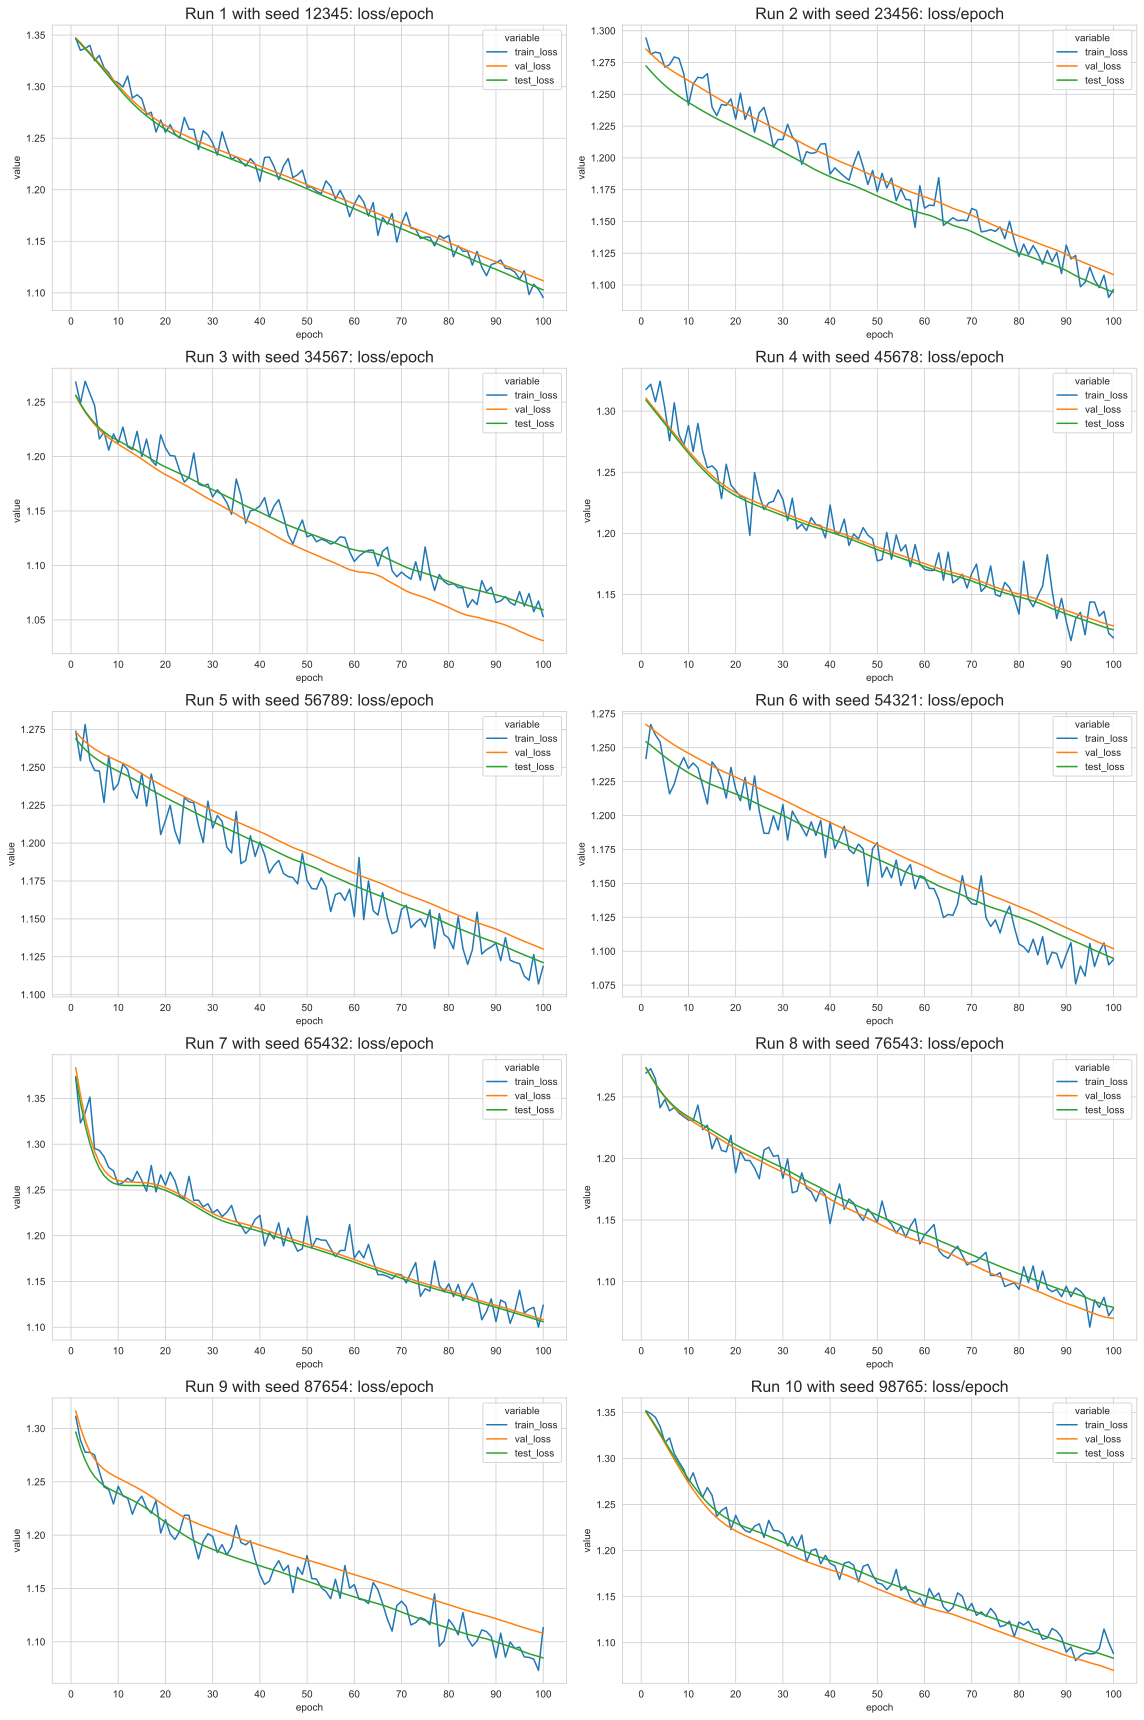

In [13]:
plot_losses_and_accuracies('loss', gae_results, 75, 10.0, 'gae_loss', True)

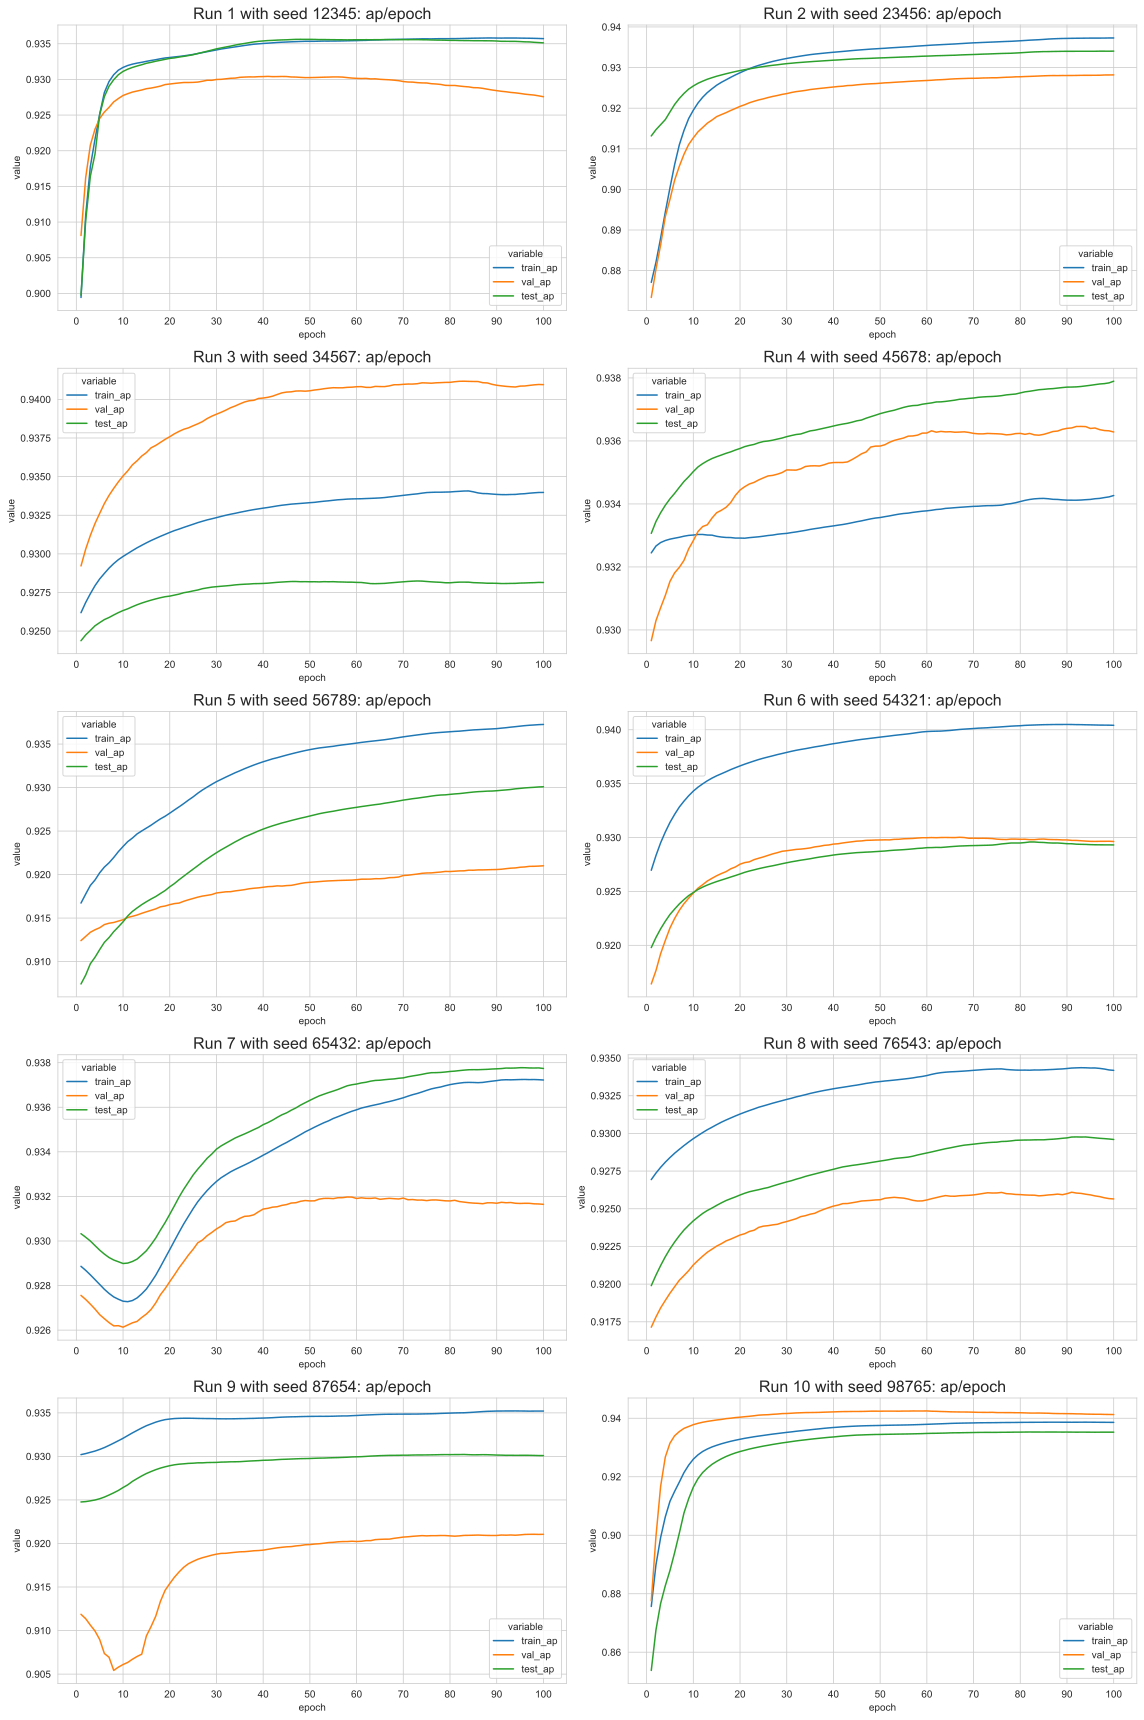

In [14]:
plot_losses_and_accuracies('ap', gae_results, 75, 10.0, 'gae_ap', True)

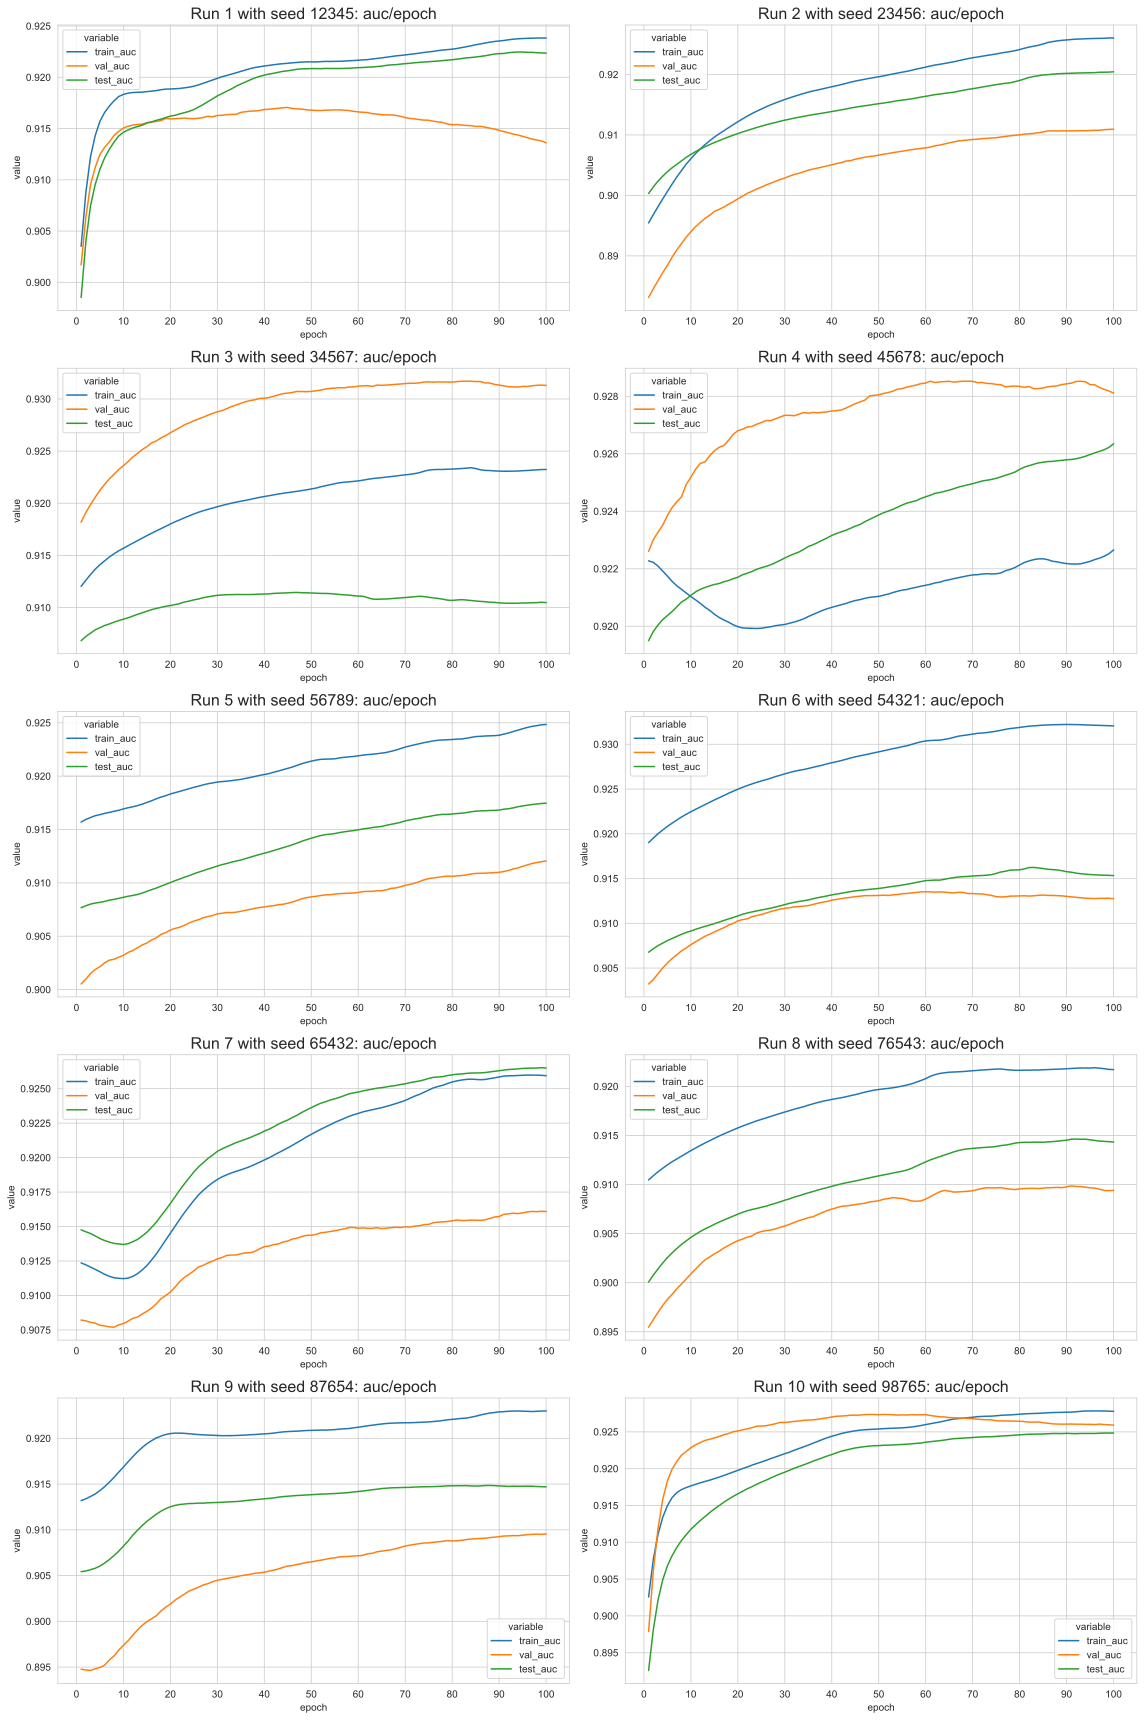

In [15]:
plot_losses_and_accuracies('auc', gae_results, 75, 10.0, 'gae_auc', True)